
meta-estimator:

An estimator which takes another estimator as a parameter.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/



# kNN approach to finding traces with flipped polarity in seismic data

We use ML to classify the polarity $(\pm 1)$ of seismic traces. Each trace corresponds to a hydrophone which listens for sound wave reflecting from the geology in the subsurface of the Earth. The sound waves have "shots" as their sources. These shots are denotations set off above the ground.

Sometimes the channel arrays have geophones which are recording data with a phase inversion of -1. That is, they record -f(t) when they should be recording f(t). To process seismic data into a tomographic image, these flipped polarity traces need to be identified.

This open source seismic data comes with channels that have this error. We use a nearest-neighbors algorithm to catalog them.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

## Reading in and cleaning the data

In [117]:
raw_data = pd.read_csv('/Users/cabrera/Documents/10_python_coding/550_seismic_trace_polarity/seismic_traces.txt',header=None,skiprows=[0])[0]

The data is being read as series:

In [118]:
raw_data.shape

(5391360,)

But each datapoint is made up of 51 attributes and a target label $(\pm 1)$, so we need to reorganize:

In [5]:
raw_data.head(5)

,0
0,channel=1 shot=2372 label=-1
1,0 1.35109469e-01
2,1 -1.49369106e-01
3,2 1.57715330e+01
4,3 1.42361059e+01


In [126]:
def series_to_dataframe(series,length,sample):
    #function to convert series to dataframe such that entries
    #within [i,i+52], i % sample = 0, are mapped to a column
    #length = total entries from series to be mapped to the dataframe
    
    return pd.DataFrame({k: series[k*sample:(k+1)*sample].array for k in range(length//sample)})

In [128]:
traces_df = series_to_dataframe_2(raw_data,len(raw_data)//2,52)

In [129]:
traces_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51830,51831,51832,51833,51834,51835,51836,51837,51838,51839
0,channel=1 shot=2372 label=-1,channel=9 shot=2372 label=1,channel=17 shot=2372 label=1,channel=25 shot=2372 label=1,channel=33 shot=2372 label=1,channel=41 shot=2372 label=-1,channel=49 shot=2372 label=1,channel=57 shot=2372 label=1,channel=65 shot=2372 label=1,channel=73 shot=2372 label=1,...,channel=2225 shot=6668 label=1,channel=2233 shot=6668 label=1,channel=2241 shot=6668 label=-1,channel=2249 shot=6668 label=1,channel=2257 shot=6668 label=1,channel=2265 shot=6668 label=1,channel=2273 shot=6668 label=1,channel=2281 shot=6668 label=-1,channel=2289 shot=6668 label=1,channel=2297 shot=6668 label=1
1,0 1.35109469e-01,0 1.45933300e-01,0 -6.92833722e-01,0 -5.48514366e-01,0 -5.12570068e-02,0 -8.86980057e-01,0 -1.76063627e-01,0 2.22643271e-01,0 1.17118979e+00,0 5.71239889e-01,...,0 -5.05644798e+01,0 -5.35335121e+01,0 5.16573334e+01,0 -6.36245384e+01,0 -6.22858963e+01,0 -6.69708176e+01,0 -6.17421837e+01,0 4.24557686e+01,0 -3.49117241e+01,0 -3.27148094e+01
2,1 -1.49369106e-01,1 1.75313914e+00,1 1.99631679e+00,1 3.04945016e+00,1 2.88342237e+00,1 -1.33383894e+00,1 1.71477425e+00,1 1.66236949e+00,1 2.14069176e+00,1 1.45541644e+00,...,1 -2.43941898e+01,1 -2.50681992e+01,1 1.98644161e+01,1 -2.24622288e+01,1 -1.41626024e+01,1 -1.40747652e+01,1 -7.30249357e+00,1 1.30712271e+01,1 -8.87607956e+00,1 -1.96998653e+01
3,2 1.57715330e+01,2 -1.49585085e+01,2 -2.35901699e+01,2 -2.49880772e+01,2 -3.32448540e+01,2 2.98935757e+01,2 -3.22538071e+01,2 -2.51346836e+01,2 -1.51347399e+01,2 -5.07944202e+00,...,2 -2.13396549e+01,2 -1.86809387e+01,2 2.29194832e+01,2 -1.65655098e+01,2 -2.28135605e+01,2 -2.79594479e+01,2 -2.25943642e+01,2 3.03915577e+01,2 -2.37743130e+01,2 -2.82103367e+01
4,3 1.42361059e+01,3 -1.81383457e+01,3 -1.35441465e+01,3 -7.66792870e+00,3 -1.11441040e+01,3 1.45502367e+01,3 -1.61157742e+01,3 -1.30265388e+01,3 -2.11821022e+01,3 -3.24019890e+01,...,3 -1.31772375e+01,3 -7.91394949e+00,3 2.81915817e+01,3 -2.24558468e+01,3 -3.33276749e+01,3 -3.37345467e+01,3 -2.52948914e+01,3 2.34377728e+01,3 -1.42750978e+01,3 -7.85312891e+00


In [122]:
def select_amplitude(x):
    #function to select the amplitude value from each cell:
    # '2 -2.35901699e+01'  ---> '-2.35901699e+01'
    
    ls = x.split()
    return ls[len(ls)-1]

def pickSign(str):      
    # function to pick send 'gut=-1' ---> -1, 'gut=1' ---> 1
    
    if str[-2:-1]=='-':
        return -1
    else:
        return 1

In [132]:
#Select amplitude value from each cell. 
#Transpose so that the samples of the traces become attributes
data_df = traces_df.applymap(select_amplitude).transpose()

#Create integer target label
data_df['Polarity']= data_df[0].apply(pickSign)
data_df = data_df.drop(labels=[0],axis=1)
data_df = data_df.astype('float')

Now we have the data in the shape that we want. Every row corresponds to a data point, with the entries being the samples of the recorded sound waves. The last column contains the polarity label.

In [130]:
data_df.head()

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,Polarity
0,0.135109,-0.149369,15.771533,14.236106,-35.925736,26.909462,-15.012988,1.725460,7.095699,1.463356,...,3.210323,-6.106526,-6.634347,7.872420,6.820869,-4.395456,7.422894,17.544140,3.223560,-1.0
1,0.145933,1.753139,-14.958509,-18.138346,24.836264,-1.771277,6.107979,0.650433,12.429290,-20.766388,...,-6.895596,-2.262812,0.867932,6.583002,-2.523254,1.952146,-1.058738,0.687788,5.562509,1.0
2,-0.692834,1.996317,-23.590170,-13.544147,16.388670,-2.811234,0.292026,19.967159,18.820869,-14.062235,...,5.066412,-4.839576,-7.733660,3.416450,-2.488747,-0.623854,-5.784183,-1.940175,3.148644,1.0
3,-0.548514,3.049450,-24.988077,-7.667929,17.888163,-11.045793,9.761217,11.444410,4.486601,-8.396764,...,8.914586,4.633519,-0.462167,-4.352639,-6.807166,4.047869,5.908732,-9.539698,-5.924528,1.0
4,-0.051257,2.883422,-33.244854,-11.144104,16.647282,-15.133264,21.228491,4.141500,11.930402,-1.909803,...,5.179042,-3.362991,6.316719,8.003730,-8.228494,-1.989292,13.240460,7.562987,-2.874917,1.0


We have a total of 51840 observations, each characterized by 51 attributes:

In [133]:
data_df.shape

(51840, 52)

Below we plot a generic observation:

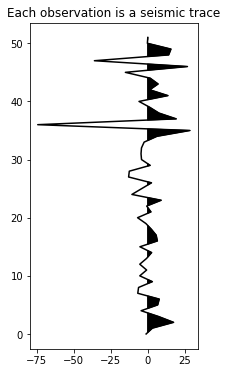

In [113]:
y=np.array(range(len(data_df.loc[0])))
y=np.flip(y)
x=data_df.loc[0]

plt.figure(figsize=(3,6))
plt.plot(x,y,c='k')
plt.fill_betweenx(y,x,0,where=x>0,interpolate=True, color='k')
plt.title('A generic observation is a seismic trace')
plt.show()

## Training/testing split. Resampling the data

We note that the data is imbalanced. So we we address this issue by resampling the number of negative-polarity traces by upsampling this category.

Note: With resampling done we can use `accuracy` as our metric.


In [10]:
print('Number of seismic traces with positive polarity =', len(data_df[data_df.Polarity == 1]))
print('Number of seismic traces with negative polarity =', len(data_df[data_df.Polarity == -1]))

Number of seismic traces with positive polarity = 41400
Number of seismic traces with negative polarity = 10440


### Training/testing split

In [10]:
#train/test split
X = data_df.drop(labels='Polarity',axis=1)
y = data_df['Polarity']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

#### Question: Should we normalize the attributes?

Generally I would say yes, normalize the data! Normalization in this case means standardization, i.e., transform the attributes such that for every predictor we have mean = 0 and variance normalized to unity.

For this particular problem, I say that we should not perform standardization though. The reason is that all the attributes belong to the same type of data already. If we had other types of attributes such as dip angles, frequency information, spatial coordinates, or hardware attributes then we would need to put all the attributes on the same footing. That's not the case here.

To check what's the best approach, we will have two parallel tracks. One where we model using the data as is, after the training-testing split. The second approach will be to standardize the data. At the end we can compare both approaches.

In [61]:
# Standardizing the attributes

def standardize(training_set, testing_set):
    #function outputs the same dataframes but features are standardized to 0 mean and unit variance
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler().fit(training_set)
    training_scaled = pd.DataFrame(scaler.transform(training_set),index=training_set.index)
    testing_scaled = pd.DataFrame(scaler.transform(testing_set),index=testing_set.index)
    
    return training_scaled, testing_scaled

The datasets `X_train_scaled` and `X_test_scaled` created below will be the data used for the standardized modeling:

In [68]:
# Create copy of data with standardized attributes:
X_train_scaled, X_test_scaled = standardize(X_train,X_test)

###  Resampling

Now that we have already split the data into training and testing sets, we can think about resampling. The reason we wait until after the split is because we will be upsampling the minority class. If this step was done on the complete dataset, then we would be creating data leakage as copies of elements of the minority class would be sent to the training and testing sets. 

By the same argument, we will not upsample the full training set either just yet. Instead, our approach is to upsample during the cross-validation procedure. If done beforehand, we would have copies of the minority class going into the training folds and the validation folds. Therefore we will apply the upsampling only to the training folds during cross-validation.

There are two basic ways to do upsampling: performing random oversampling (ROS) and creating synthetic elements of the minority class (for example via `imbalanced-learn` SMOTE algorithm). In this notebook we use the simpler ROS approach.

In [30]:
from sklearn.utils import resample

def binary_upsample(attributes, target, resampling_value, n_ratio, verbose=False):
    #function to resample data using Random Oversampling 
    #attributes = df with attributes. target = series with target values. 
    #n_ratio = desired majority/minority class ratio after upsampling
    #resampling_value = target value of minority class
    #'binary' because it works with two classes
    
    
    all_data = attributes.copy()
    all_data['target'] = target
    
    if verbose:
        print('\n~~~~~~~~~~ Before resampling training data:\n ')
        print('Total number of observations', len(all_data))
        print('Imbalance ratio = {length:.2f}'.format(length =len(all_data[all_data.target != resampling_value])/len(all_data[all_data.target == resampling_value])))
    
    #create new samples
    n_samples = int(len(all_data[all_data.target != resampling_value]) / n_ratio)
    new_samples = resample(all_data[all_data.target == resampling_value],n_samples = n_samples, random_state=0)
    resampled_data = pd.concat([all_data[all_data.target != resampling_value],new_samples])
    
    #Peel off the labels again
    attributes_resampled = resampled_data.drop(labels='target',axis=1)
    target_resampled = resampled_data['target']
    
    if verbose:
        print('\n~~~~~~~~~~ After upsampling training data:\n ')
        print('Total number of observations =', len(resampled_data))
        print('Imbalance ratio = {frac:.2f}'.format(frac= len(resampled_data[resampled_data.target != resampling_value])/len(resampled_data[resampled_data.target == resampling_value])) )
   

    return attributes_resampled, target_resampled

# Building the nearest-neighbors model
We proceed to build the model with balanced training data. We will compare modeling using the standardized vs. non-standardized datasets.

We first need to find the optimal k, the number of neighbors, via cross validation. The function `kNN_upsample_CV` does cross-validation while upsampling training sets for each fold at once. Since this is a classification problem with balanced training data, we test for accuracy.

In [29]:
from sklearn.model_selection import KFold

def kNN_upsample_CV(attributes, target, cv_partitions, resampling_value, n_ratio):
    # function to do cross-validation on kNN while upsampling minority class
    # calls binary_upsample on the training set and not on the validation set
    # attributes = dataframe of attributes. target = target series
    # cv_partitions = # of folds
    # resampling_value = target value of minority class. 
    # n_ratio = desired resampled imbalance ratio. 
    
    
    kfolds = KFold(n_splits=cv_partitions, shuffle=False)
    
    mean_scores = []
    
    for k in range(1,14,2): # k in kNN (use 1,14,2)
        
        scores_fixed_k = []
        
        for train_index,test_index in kfolds.split(attributes):  # kfolds for CV
            
            X_train_resampled, y_train_resampled = binary_upsample(attributes.iloc[train_index], 
                                                                   target.iloc[train_index], resampling_value, n_ratio)
            
            knn = KNeighborsClassifier(n_neighbors=k,weights='uniform')
            knn.fit(X_train_resampled, y_train_resampled)
            scores_fixed_k.append(knn.score(attributes.iloc[test_index],target.iloc[test_index]))
            
        mean_scores.append(np.mean(scores_fixed_k))
            
    
    #misclassification error and optimal k
    msc = [1 - x for x in mean_scores]
    optimal_msc = (list(range(1,14,2)))[msc.index(min(msc))]
    print('Minimum misclassification error at k =', optimal_msc)
    
    
    return mean_scores

Get cross-validation scores for the non-standardized training dataset:

In [60]:
cv_scores = kNN_upsample_CV(X_train,y_train,cv_partitions=3,resampling_value=-1,n_ratio=1)

Minimum misclassification error at k = 1


Get cross-validation scores for the standardized training dataset:

In [64]:
cv_scores_s = kNN_upsample_CV(X_train_scaled,y_train, cv_partitions=3,resampling_value=-1,n_ratio=1)

Minimum misclassification error at k = 1


We observe that for both the non-standardized and the standardized models we obtain `k = 1` as the optimal value.


### Understading k = 1
Note: the value of k in kNN parametrizes the space of kNN models. Geometrically, it is a measure of the irregularity of the decision boundary. A smaller k means that the decision is being made more locally. Small values of k sometimes indicate we may have overfitting. Yet, in the problem at hand `k = 1` makes sense as we explain below.

If two receivers in the field that are close together, in the actual xyz-coordinates, then they will be probing very similar geology for any fixed source. This means that the traces they generated will be very similar. Another way to say it is that the resulting traces will be close together in the trace or attribute space (which is a 51-dimensional vector space in this problem). Now, if we randomly flip one of the receivers then the resulting trace will be reflected across the origin of the attribute space.

The above means that to find out the polarity of any one given trace, we only need ask the nearest neighbor. 

### We can finally answer the posited question: standardize or not standardize?

Below we plot the resulting misclassification errors `(1-accuracy)` coming out of cross-validation for each case. Indeed, we see that for all values of k, the non-standardized model has a lower error than the standardized case as we had predicted!


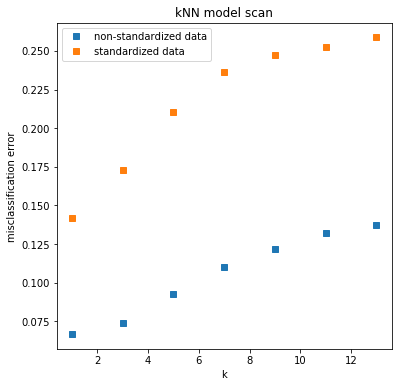

In [65]:
plt.figure(figsize=(6,6))
plt.plot((list(range(1,14,2))),[1-x for x in cv_scores],'s')
plt.plot((list(range(1,14,2))),[1-x for x in cv_scores_s],'s')
plt.xlabel('k')
plt.ylabel('misclassification error')
plt.title('kNN model scan')
plt.legend(['non-standardized data', 'standardized data'])
plt.show()

## Evaluate the classifiers on the test data.

We use the full training data to build the model. The full training data gets resampled first.

In [15]:
#upsampling non-standardized version
X_train_r, y_train_r = binary_upsample(X_train, y_train, resampling_value=-1, n_ratio = 1, verbose=True)


~~~~~~~~~~ Before resampling training data:
 
Total number of observations 38880
Imbalance ratio = 3.97

~~~~~~~~~~ After upsampling training data:
 
Total number of observations = 62122
Imbalance ratio = 1.00


In [16]:
#upsampling standardized version
X_train_scaled_r, y_train_r = binary_upsample(X_train_scaled, y_train, resampling_value=-1, n_ratio = 1, verbose=True)

NameError: name 'X_train_scaled' is not defined

In [17]:
#non-standardized model
knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train_r,y_train_r)
print('\n The non-standardized kNN-model has accuracy = {score:.2f}'.format(score = knn1.score(X_test,y_test)))


 The non-standardized kNN-model has accuracy = 0.95


In [73]:
#standardized model
knn1_scaled = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train_scaled_r,y_train_r)
print('The standardized kNN-model has accuracy = {score:.2f}'.format(score = knn1_scaled.score(X_test_scaled,y_test)))

The standardized kNN-model has accuracy = 0.88


#### Baseline of dummy classifier

Sanity check: How do we compare with against dummy classifiers? 


In [23]:
from sklearn.dummy import DummyClassifier

dummy_frequent = DummyClassifier(strategy='most_frequent').fit(X_train_r,y_train_r)

print('The most-frequent classifier has accuracy = {score:.2f}'.format(score = dummy_frequent.score(X_test,y_test)))

The most-frequent classifier has accuracy = 0.80


### Other metrics

- In our case, the recall score is the most important one since we care about minimizing _false negatives_ which in our case means minimizing the number of polarity=-1 being labeled as polarity=+1.

- Precision takes a back seat here because erroneously labeling good traces as polarity=-1 only means a few more receivers to QC.


We will see that the non-standardized model clearly beats the standardized model when it comes to recall score (true-positive rate).

The function `otherScores` will print out the recall score for a given model and test sets, as well as the confusion matrix for the evaluation. Note: in the convention we use below is as follows. For the confusion matrix C:
- C[0,0] = true positive class: negative polarity traces classified as such.
- C[1,1] = true negative class: positive polarity traces classifies as such.
- C[0,1] = false negative class: negative polarity traces classifies as positive polarity.

In [76]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
    
def otherScores(model,X_test,y_test):
    #function (1) plots confusion matrix for given model and data
    #         (2) prints recall score
    
    from sklearn.metrics import plot_confusion_matrix
    fig = plot_confusion_matrix(model,X_test,y_test,values_format='d')
    fig.ax_.set_title('Confusion matrix')
    plt.show()
    
    print('\n Recall score = {score:.2f}'.format(score = recall_score(y_test,model.predict(X_test),pos_label=-1)))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')

Non-standardized case: ~~~~~~~~~~~~



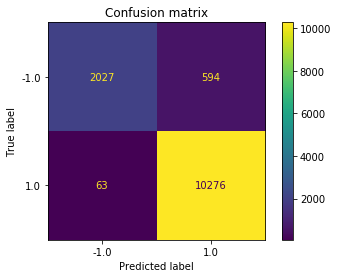


 Recall score = 0.77
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Standardized case: ~~~~~~~~~~~~



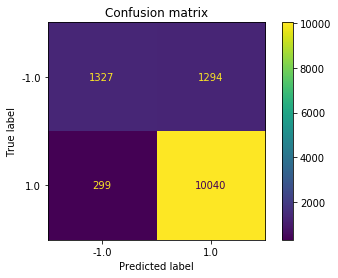


 Recall score = 0.51
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [57]:
print('Non-standardized case: ~~~~~~~~~~~~\n')
otherScores(knn1,X_test,y_test)

print('Standardized case: ~~~~~~~~~~~~\n')
otherScores(knn1_scaled,X_test_scaled,y_test)

# Bagging ensemble with k = 1 kNN base estimator

Now that we have settled on the 1NN model without standardization of the features, we can use an ensemble of this base estimator to reduce the noise and variance. For this purpose we use the Bagging algorithm which consists of training the base estimator on random subsets of the data where the subsets are created by pulling samples with raplacement.

In [20]:
from sklearn.ensemble import BaggingClassifier

selected_kNN = KNeighborsClassifier(n_neighbors=1, weights='uniform')

We first look at a baseline Bagging classifier. Even using hand-picked parameters we see that we beat the recall score of the base estimator.

In [22]:
bag_kNN_baseline = BaggingClassifier(selected_kNN, n_estimators=10, max_samples=.5, random_state=0).fit(X_train_r, y_train_r)

In [23]:
print('\n The bag_kNN_baseline model has accuracy = {score:.2f}'.format(score = bag_kNN_baseline.score(X_test,y_test)))


 The bag_kNN_baseline model has accuracy = 0.94


bag_kNN_baseline case: ~~~~~~~~~~~~



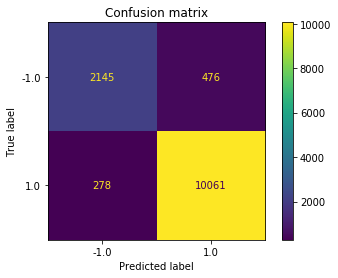


 Recall score = 0.82
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [25]:
print('bag_kNN_baseline case: ~~~~~~~~~~~~\n')
otherScores(bag_kNN_baseline,X_test,y_test)

### Cross-validation for the Bagging classifier 

We proceed to optimize the Bagging classifier by doing cross-validation to search for the best number of samples and copies of the base estimator to employ.

In [102]:
from sklearn.model_selection import ParameterGrid

def bagging_kNN_upsample_CV(attributes, target, cv_partitions, resampling_value, n_ratio, param_grid):
    # function to do cross-validation on kNN while upsampling minority class
    # calls binary_upsample on the training set and not on the validation set
    # attributes = dataframe of attributes. target = target series
    # cv_partitions = # of folds
    # resampling_value = target value of minority class. 
    # n_ratio = desired resampled imbalance ratio. 
    
    
    param_space = ParameterGrid(param_grid)
    
    kfolds = KFold(n_splits=cv_partitions, shuffle=False)
    
   
    scores = {}
    for parameters in param_space:
        
        accuracy_fixed_params= []
        recall_fixed_params = []
        
        for train_index,test_index in kfolds.split(attributes):  # kfolds for CV
            X_train_resampled, y_train_resampled = binary_upsample(attributes.iloc[train_index], 
                                                                   target.iloc[train_index], resampling_value, n_ratio)
            
            bag_clsf = BaggingClassifier(selected_kNN, **parameters).fit(X_train_resampled, y_train_resampled)
            y_pred = bag_clsf.predict(attributes.iloc[test_index])
            
            accuracy_fixed_params.append(accuracy_score(target.iloc[test_index], y_pred))
            recall_fixed_params.append(recall_score(target.iloc[test_index], y_pred, pos_label=-1))
            

        
        scores[str(parameters)] = [np.mean(accuracy_fixed_params), np.mean(recall_fixed_params)] 
        
        
    return scores

In [105]:
param_grid_1 = {'n_estimators' : [5, 10, 15], 'max_samples': [.25, .5, .75,]}

results1 = bagging_kNN_upsample_CV(X_train, y_train, cv_partitions=3, resampling_value=-1, n_ratio=1, param_grid=param_grid_1)

In [106]:
results1

{"{'max_samples': 0.25, 'n_estimators': 5}": [0.8979166666666666,
  0.7809123930335385],
 "{'max_samples': 0.25, 'n_estimators': 10}": [0.8997942386831276,
  0.8100924966966608],
 "{'max_samples': 0.25, 'n_estimators': 15}": [0.9131687242798354,
  0.7942400758482616],
 "{'max_samples': 0.5, 'n_estimators': 5}": [0.9218106995884773,
  0.7632776528403157],
 "{'max_samples': 0.5, 'n_estimators': 10}": [0.9219393004115227,
  0.7800678451303371],
 "{'max_samples': 0.5, 'n_estimators': 15}": [0.926440329218107,
  0.7659636152461301],
 "{'max_samples': 0.75, 'n_estimators': 5}": [0.9276491769547325,
  0.7462384741222395],
 "{'max_samples': 0.75, 'n_estimators': 10}": [0.9288580246913579,
  0.7572623359741252],
 "{'max_samples': 0.75, 'n_estimators': 15}": [0.9305041152263375,
  0.7421858586280424]}

In [109]:
bag_kNN_2 = BaggingClassifier(selected_kNN, n_estimators=10, max_samples=.25, random_state=0).fit(X_train_r, y_train_r)
print('\n The bag_kNN model with {max_samples: 0.25, n_estimators: 10} has accuracy =', '{score:.2f}'.format(score = bag_kNN_2.score(X_test,y_test)))


 The bag_kNN model with {max_samples: 0.25, n_estimators: 10} has accuracy = 0.92


bag_kNN {max_samples: 0.25, n_estimators: 10} case: ~~~~~~~~~~~~



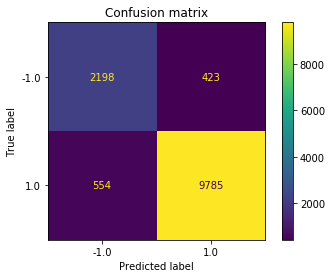


 Recall score = 0.84
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [110]:
print('bag_kNN {max_samples: 0.25, n_estimators: 10} case: ~~~~~~~~~~~~\n')
otherScores(bag_kNN_2, X_test, y_test)

## Conclusions

kNN is a good approach to tackling the question of predicting flipped polarity traces. Furthermore, it performs quite well without any information about the hardware set up in the field, that is, we have not used coordinates or receivers identifying information in our modeling.

How to improve the model: 
- include more amplitude samples to get lower amplitude noise,
- change upsampling technique from random oversampling to SMOTE. That is, don't make carbon copies of the minority class elements, create synthetic elemenents instead. I generally see better results with SMOTE.

Furthermore, building the Bagging classifier on top of the kNN estimator gives a much better model with a significant improvement in the recall score.